In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import functools
import math
import numpy as np
import itertools
from grid import load, print_info

def mean(x):
    x = list(x)
    return sum(x) / len(x)

def median(x):
    x = sorted(list(x))
    return x[len(x) // 2]

def triangle(a, b, c, d=None, slope=None, other=False, color=None, fmt="{:.2f}", textpos=None):
    import math
    
    if slope is not None and d is None:
        d = math.exp(math.log(c) + slope * (math.log(b) - math.log(a)))
    if slope is not None and c is None:
        c = math.exp(math.log(d) - slope * (math.log(b) - math.log(a)))
    if color is None:
        color = 'k'

    plt.plot([a, b], [c, d], color=color)
    if other:
        plt.plot([a, b], [c, c], color=color)
        plt.plot([b, b], [c, d], color=color)
    else:
        plt.plot([a, b], [d, d], color=color)
        plt.plot([a, a], [c, d], color=color)

    s = (math.log(d) - math.log(c)) / (math.log(b) - math.log(a))
    if other:
        x = math.exp(0.7 * math.log(b) + 0.3 * math.log(a))
        y = math.exp(0.7 * math.log(c) + 0.3 * math.log(d))
    else:
        x = math.exp(0.7 * math.log(a) + 0.3 * math.log(b))
        y = math.exp(0.7 * math.log(d) + 0.3 * math.log(c))
    if textpos:
        x = textpos[0]
        y = textpos[1]
    plt.annotate(fmt.format(s), (x, y), horizontalalignment='center', verticalalignment='center')
    return s

def nd(x, a):
    assert not torch.isnan(x['outputs']).any()
    return (a * x['outputs'] * x['labels'] < 1).nonzero().numel()

def err(x):
    assert not torch.isnan(x['outputs']).any()
    return (x['outputs'] * x['labels'] <= 0).double().mean().item()

def enserr(xs):
    f = mean(x['outputs'] for x in xs)
    y = xs[0]['labels']
    assert all((x['labels'] == y).all() for x in xs)
    return (f * y <= 0).double().mean().item()

def var(outs, alpha):
    otr = alpha * torch.stack(outs)
    return otr.sub(otr.mean(0)).pow(2).mean(1).sum(0).item() / (otr.size(0) - 1)

def texnum(x, mfmt='{}'):
    m, e = "{:e}".format(x).split('e')
    m, e = float(m), int(e)
    mx = mfmt.format(m)
    if e == 0:
        if m == 1:
            return "1"
        return mx
    ex = "10^{{{}}}".format(e)
    if m == 1:
        return ex
    return "{}\;{}".format(mx, ex)

def logfilter(x, y, num):
    import numpy as np
    import scipy.ndimage
    x = np.array(x)
    y = np.array(y)
    x = np.log(x)
    xi = np.linspace(min(x), max(x), num)
    yi = np.interp(xi, x, y)
    yf = scipy.ndimage.filters.gaussian_filter1d(yi, 2)
    return np.exp(xi), yf

def yavg(xi, x, y):
    import numpy as np
    xi = np.array(xi)
    xmin = min(np.min(x) for x in x)
    xmax = min(np.max(x) for x in x)
    xi = xi[np.logical_and(xmin < xi, xi < xmax)]
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

# Setup

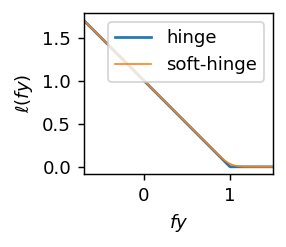

In [2]:
fig, ax1 = plt.subplots(1, 1, figsize=(2.3, 2), dpi=130)


plt.sca(ax1)
x = torch.linspace(-0.7, 1.5, 200)
plt.plot(x, x.neg().add(1).relu(), label='hinge')
plt.plot(x, torch.nn.functional.softplus(x.neg().add(1), beta=20), label='soft-hinge', linewidth=0.9)

plt.legend()
plt.xlabel(r'$fy$')
plt.ylabel(r'$\ell(fy)$')
plt.xlim(min(x), max(x))

plt.tight_layout()
plt.savefig('loss.pgf')

# Disentangling feature learning versus lazy learning from performance

`python -m grid F10k3Lsp_h_init --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --regular 0 --final_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --tau_over_h 1e-3 --max_dgrad 1e-4 --lossbeta 20" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1 --h:int 10 14 19 27 37 52 72 100 139 193 268 373 518 720 1000 1390` 

`python -m grid F10k3Lsp_h --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --regular 1 --final_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --tau_over_h 1e-3 --max_dgrad 1e-4 --lossbeta 20" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1e-4 1e-2 1e0 1e2 1e4 --h:int 10 14 19 27 37 52 72 100 139 193 268 373 518 720 1000 1390`

`python -m grid F10k3Lsp_alpha --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --lossbeta 20 --tau_over_h 1e-3 --max_dgrad 1e-4" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100 300 1000`

100%|██████████| 690/690 [00:00<00:00, 211153.49it/s]


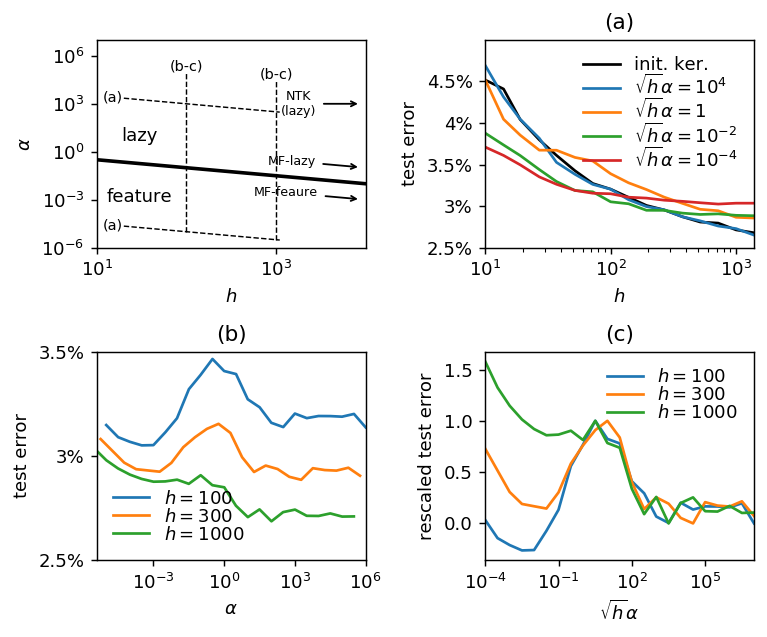

In [6]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)

plt.sca(ax1)
plt.plot([10, 10000], [10 ** -0.5, 10000 ** -0.5], 'k', linewidth=2)

plt.xscale('log')
plt.yscale('log')

plt.xlim(10, 10000)
plt.ylim(1e-6, 1e7)

plt.annotate(r"feature", (3e1, 1.5e-3), horizontalalignment='center', verticalalignment='center')
plt.annotate(r"lazy", (3e1, 1e1), horizontalalignment='center', verticalalignment='center')

plt.annotate("NTK\n(lazy)", xy=(9e3, 1e3), xytext=(1.8e3, 1e3), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')
plt.annotate("MF-lazy", xy=(9e3, 10 * 9e3 ** -0.5), xytext=(15e2, 10 * 15e2 ** -0.5), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')
plt.annotate("MF-feaure", xy=(9e3, 0.1 * 9e3 ** -0.5), xytext=(13e2, 0.1 * 13e2 ** -0.5), fontsize=7, arrowprops=dict(arrowstyle="->"), horizontalalignment='center', verticalalignment='center')

plt.plot([20, 1100], [1e-4 * 20 ** -0.5, 1e-4 * 1100 ** -0.5], '--k', linewidth=0.8)
plt.plot([20, 1100], [1e4 * 20 ** -0.5, 1e4 * 1100 ** -0.5], '--k', linewidth=0.8)
plt.plot([100, 100], [1e-4 * 100 ** -0.5, 1e6 * 100 ** -0.5], '--k', linewidth=0.8)
plt.plot([1000, 1000], [1e-4 * 1000 ** -0.5, 1e6 * 1000 ** -0.5], '--k', linewidth=0.8)
plt.annotate(r"(a)", (1.5e1, 2.5e3), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(a)", (1.5e1, 2.5e-5), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(b-c)", (1e2, 2e5), fontsize=8, horizontalalignment='center', verticalalignment='center')
plt.annotate(r"(b-c)", (1e3, 7e4), fontsize=8, horizontalalignment='center', verticalalignment='center')

plt.xlabel(r'$h$')
plt.ylabel(r'$\alpha$')



plt.sca(ax2)
runs = load("F10k3Lsp_h_init")
runs = [r for r in runs if 'init_kernel' in r]
runs = [r for r in runs if nd(r['init_kernel']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

runs = load("F10k3Lsp_h", predicate=lambda args: args.alpha in [1e-4, 1e-2, 1e0, 1e4])
runs = [r for r in runs if 'regular' in r]
runs = [r for r in runs if not torch.isnan(r['regular']['test']['outputs']).any()]
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

for a in sorted({r['args'].alpha for r in runs}, reverse=True):
    rs = [r for r in runs if r['args'].alpha == a]

    hs = sorted({r['args'].h for r in rs})
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].h == h) for h in hs]
    plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))


plt.yticks([0, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], ['0', '1%', '2%', '2.5%', '3%', '3.5%', '4%', '4.5%'])
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error')
plt.ylim(0.025, 0.05)
plt.xlim(10, 1390)
plt.title('(a)')






plt.sca(ax3)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    xs = [a / h**0.5 for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(xs, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\alpha$')
plt.ylabel('test error')
plt.yticks([0, 0.01, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045], ['0', '1%', '2%', '2.5%', '3%', '3.5%', '4%', '4.5%'])
plt.xlim(4e-6, 1e6)
plt.ylim(0.025, 0.035)
plt.title('(b)')



plt.sca(ax4)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    m1 = min(v for a, v in zip(als, vs) if a > 1e-1)
    m2 = max(v for a, v in zip(als, vs) if a > 1e-1)
    vs = [(x - m1) / (m2 - m1) for x in vs]
    plt.plot(als, vs, label=r'$h = {}$'.format(h))

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel(r'$\sqrt{h} \alpha$')
plt.ylabel('rescaled test error')
plt.xlim(min(als), max(als))
plt.title('(c)')


plt.tight_layout()
plt.savefig('test_error.pgf')

# Fluctuations of output function and effect of ensemble averaging

`python -m grid F1k3Lsp_h --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --regular 1 --final_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 1000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --tau_over_h 1e-3 --max_dgrad 1e-4 --lossbeta 20" --init_seed 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 --alpha 1e-4 1e-2 1e0 1e2 1e4 --h:int 27 37 52 72 100 139 193 268 373 518 720 1000 1390 1930 2680 3720 5170`

100%|██████████| 1700/1700 [00:00<00:00, 286392.61it/s]


[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
20
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
20
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
20


  0%|          | 0/690 [00:00<?, ?it/s]

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
20
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
20


100%|██████████| 690/690 [00:00<00:00, 218519.31it/s]


690
690
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10


100%|██████████| 690/690 [00:00<00:00, 191927.17it/s]


[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10


100%|██████████| 1010/1010 [00:00<00:00, 27343.68it/s]


[9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10


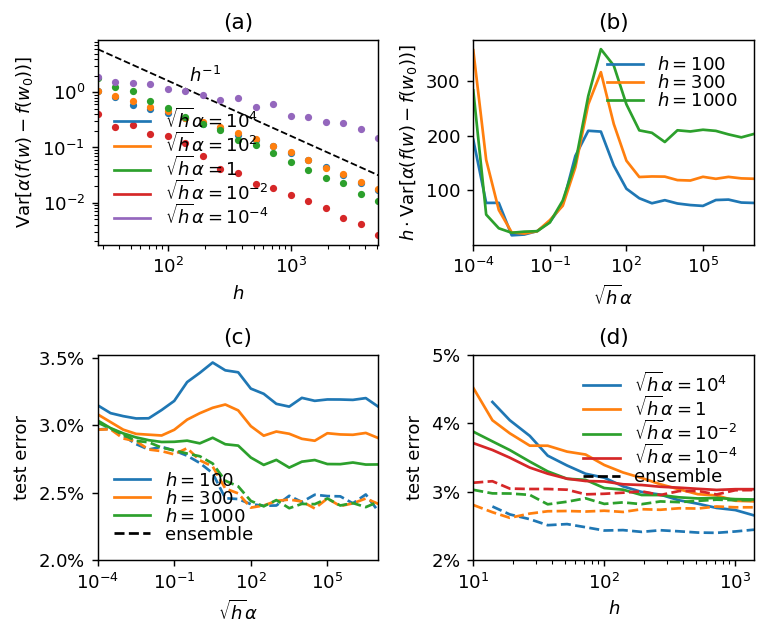

In [31]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)


plt.sca(ax1)
runs = load("F1k3Lsp_h")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

als = sorted({r['args'].alpha for r in runs})

for a in reversed(als):
    rs = [r for r in runs if r['args'].alpha == a]
    hs = sorted({r['args'].h for r in rs})
    print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 20
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})
    vs = [var([r['regular']['test']['outputs'] for r in rs if r['args'].h == h], a) for h in hs]
    [line, _, _] = plt.errorbar(hs, vs, fmt='.')
    plt.plot([], [], label=r'$\sqrt{{h}}\alpha = {}$'.format(texnum(a)), color=line.get_color())

plt.xlim(27, 5170)
plt.yscale('log')
plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.ylabel(r'$\mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
a, b = plt.xlim()
for c in [6]:
    plt.plot([a, b], [c, c * (b / a) ** -1], 'k--', linewidth=1, zorder=-10)
plt.annotate(r"$h^{-1}$", (2e2, 2e0), horizontalalignment='center', verticalalignment='center')
plt.xlabel(r'$h$')
plt.title('(a)')




plt.sca(ax2)
runs = load("F10k3Lsp_alpha")
print(len(runs))
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
print(len(runs))

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [h * var([r['regular']['test']['outputs'] for r in rs if r['args'].alpha == a], a) for a in als]
    plt.plot(ws, vs, label=r'$h = {}$'.format(h))
    
plt.xscale('log')
plt.legend(frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel(r'$h \cdot \mathrm{Var}[ \alpha(f(w) - f(w_0)) ]$')
plt.xlim(1e-4, 1e7)
plt.title('(b)')




plt.sca(ax3)
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a for a in als]
    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(ws, vs, label=r'$h = {}$'.format(h))
    
    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(ws, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(1e-4, 1e7)
y = [2, 2.5, 3, 3.5]
plt.yticks([y / 100 for y in y], [r'${:.1f}\%$'.format(y) for y in y])
plt.title('(c)')





plt.sca(ax4)
runs = load("F10k3Lsp_h", predicate=lambda args: args.alpha in [1e-4, 1e-2, 1e0, 1e4])
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

als = sorted({r['args'].alpha for r in runs})

for a in reversed(als):
    rs = [r for r in runs if r['args'].alpha == a]
    hs = sorted({r['args'].h for r in rs})
    print([len([1 for r in rs if r['args'].h == h]) for h in hs])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].h == h] for h in hs] if len(rs) >= n for r in rs[:n]]
    hs = sorted({r['args'].h for r in rs})
    
    vs = [mean([err(r['regular']['test']) for r in rs if r['args'].h == h]) for h in hs]
    [line] = plt.plot(hs, vs, label=r'$\sqrt{{h}} \alpha = {}$'.format(texnum(a)))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].h == h]) for h in hs]
    plt.plot(hs, vs, '--', color=line.get_color())

plt.xlim(10, 1390)
plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
y = [2, 3, 4, 5]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
# plt.ylim(0.055, 0.09)
plt.ylabel(r'test error')
plt.xlabel(r'$h$')
# for e in [0.0605, 0.0620]:
#     plt.plot(plt.xlim(), [e] * 2, 'k--', linewidth=1, zorder=-10)
plt.title('(d)')



plt.tight_layout()
plt.savefig('var_ens.pgf')

# Training dynamics differs in the two regimes

100%|██████████| 690/690 [00:00<00:00, 273878.09it/s]


[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
10


<Figure size 432x288 with 0 Axes>

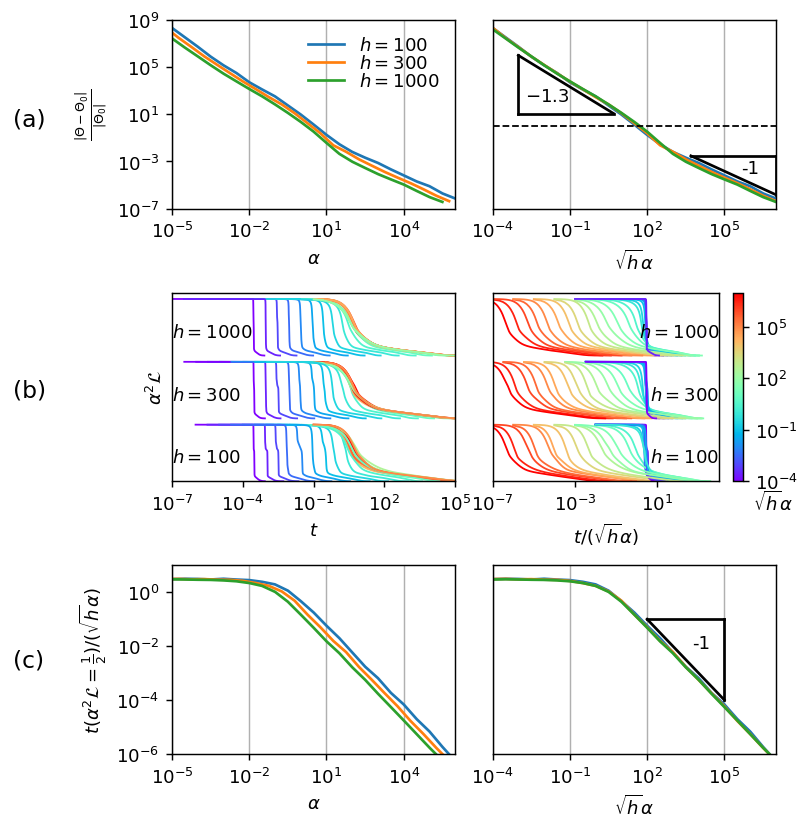

In [33]:
# Using contourf to provide my colorbar info, then clearing the figure
cmap = plt.get_cmap('rainbow')
Z = [[1,1],[1,1]]
import matplotlib.colors as colors
CS3 = plt.pcolor(Z, cmap=cmap, norm=colors.LogNorm(vmin=1e-4, vmax=1e7))
plt.clf()


runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 and 'delta_kernel' in r]

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize=(6.5, 6.5), dpi=130)

def thth0(r):
#     x = r['init_kernel']['kernel']['test']
#     th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    th0 = r['init_kernel']['kernel']['test']['norm']
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** -0.5 for a in als]

    plt.sca(ax2)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))
    
    plt.sca(ax1)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))


# y-axis
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.yscale('log')
    plt.ylim(1e-7, 1e9)
plt.sca(ax1)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

plt.sca(ax2)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False)   # labels along the bottom edge are off


# x-axis
plt.sca(ax1)
plt.grid(axis='x')
plt.xlim(1e-5, 1e6)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-4, 1e7)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax1)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1e-3, 5e0, 1e6, slope=-4/3, fmt=r"${:.1f}$")
triangle(5e3, 1e7, 3e-3, slope=-1, other=True, fmt="-1")
plt.plot(plt.xlim(), [1, 1], '--k', linewidth=1)





##
hs = sorted({r['args'].h for r in runs})

for i, h in enumerate(hs):
    label = r"$h={}$".format(h)
    plt.sca(ax3)
    plt.annotate(label, xy=(0., i/3 + 0.1), xycoords='axes fraction')
    plt.sca(ax4)
    plt.annotate(label, xy=(1., i/3 + 0.1), xycoords='axes fraction', horizontalalignment='right')

    rs = [r for r in runs if r['args'].h == h and r['args'].init_seed < 1]

    for r in rs:
        d = r['regular']['dynamics']
        color = cmap((math.log10(r['args'].alpha) + 4) / 11)

        plt.sca(ax3)
        x = [x['t'] / r['args'].h * r['args'].alpha for x in d]
        y = [i / 3 + 0.3 * x['train']['aloss'] for x in d]
        plt.plot(x, y, linewidth=1, color=color, zorder=torch.randint(-100, 0, ()).item())
        
        plt.sca(ax4)
        x = [x['t'] / r['args'].h for x in d]
        y = [i / 3 + 0.3 * x['train']['aloss'] for x in d]
        plt.plot(x, y, linewidth=1, color=color, zorder=torch.randint(-100, 0, ()).item())

for ax in [ax3, ax4]:
    plt.sca(ax)
    plt.xscale('log')
    plt.yticks([])
    plt.ylim(0, 1)

plt.sca(ax3)
plt.xlabel(r'$t$')
plt.xlim(1e-7, 1e5)
plt.ylabel(r'$\alpha^2 \mathcal{L}$')

plt.sca(ax4)
plt.xlabel(r'$t / (\sqrt{h}\alpha)$')
plt.xlim(1e-7, 1e4)
plt.colorbar(CS3) # using the colorbar info I got from contourf
plt.annotate(r"$\sqrt{h}\alpha$", xy=(1.15, -0.15), xycoords='axes fraction')

    

    
##
hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 10
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** -0.5 for a in als]

    plt.sca(ax6)
#     vs = [mean(r['regular']['dynamics'][-1]['t'] / h for r in rs if r['args'].alpha == a) for a in als]
#     [line] = plt.plot(als, vs, label=r'$h = {}$'.format(h))

    vs = [mean(
        next(x['t'] / h for x in r['regular']['dynamics'] if x['train']['aloss'] < 0.5)
        for r in rs if r['args'].alpha == a)
    for a in als]
    plt.plot(als, vs)

    plt.sca(ax5)
#     vs = [mean(r['regular']['dynamics'][-1]['t'] / h for r in rs if r['args'].alpha == a) for a in als]
#     [line] = plt.plot(ws, vs, label=r'$h = {}$'.format(h))

    vs = [mean(
        next(x['t'] / h for x in r['regular']['dynamics'] if x['train']['aloss'] < 0.5)
        for r in rs if r['args'].alpha == a)
    for a in als]
    plt.plot(ws, vs)


# y-axis
for ax in [ax5, ax6]:
    plt.sca(ax)
    plt.ylim(1e-6, 1e1)
    plt.yscale('log')
plt.sca(ax5)
plt.ylabel(r'$t(\alpha^2 \mathcal{L} = \frac{1}{2}) / (\sqrt{h}\alpha)$')

for ax in [ax4, ax6]:
    plt.sca(ax)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off

plt.sca(ax5)
plt.grid(axis='x')
plt.xlim(1e-5, 1e6)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax6)
plt.grid(axis='x')
plt.xlim(1e-4, 1e7)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax6)
triangle(1e2, 1e5, 1e-1, slope=-1, other=True, fmt="-1")

fig.text(0, 0.85, r"(a)", verticalalignment='center', horizontalalignment='left', fontsize=13)
fig.text(0, 0.53, r"(b)", verticalalignment='center', horizontalalignment='left', fontsize=13)
fig.text(0, 0.21, r"(c)", verticalalignment='center', horizontalalignment='left', fontsize=13)

plt.tight_layout(h_pad=1., w_pad=0, rect=[0.05, 0, 0.95, 1])
plt.savefig('time_dynamics.pgf')

In [ ]:
runs = load("F10k9Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 and 'delta_kernel' in r]

fig, ax2 = plt.subplots(1, 1, figsize=(4.5, 3.5), dpi=130)

def thth0(r):
#     x = r['init_kernel']['kernel']['test']
#     th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    th0 = r['init_kernel']['kernel']['test']['norm']
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])    

    plt.sca(ax2)
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '.-', label=r'$h = {}$'.format(h))
    

# y-axis
for ax in [ax2]:
    plt.sca(ax)
    plt.yscale('log')
#     plt.ylim(1e-7, 1e9)
plt.sca(ax2)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-4, 1e7)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax2)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1e-3, 5e0, 1e6, slope=-4/3, fmt=r"${:.1f}$")
triangle(5e3, 1e7, 3e-3, slope=-1, other=True, fmt="-1")
plt.plot(plt.xlim(), [1, 1], '--k', linewidth=1)



In [ ]:
runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0 and 'delta_kernel' in r]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5), dpi=130)

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    
    vs = [mean(r['regular']['dynamics'][-1]['wall'] / 60 for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '.-', label=r'$h = {}$'.format(h))
    
plt.xscale('log')

# Other

`python -m grid EM10k3Lsp_alpha --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 0 --final_kernel 0 --delta_kernel 0 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset emnist-letters --tau_alpha_crit 1e3 --lossbeta 20 --tau_over_h 1e-3 --max_dgrad 1e-4" --init_seed 0 1 2 3 4 5 6 7 8 9 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100`

`python -m grid C10kCsp_adam "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main_adam.py --data_seed 0 --batch_seed 0 --dataset cifar10 --ptr 10000 --pte 50000 --arch cv_softplus --spbeta 5 --bs 32 --lr 1e-3 --train_time 28800.0" --init_seed:int 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 --alpha:float 1e-2 1e6 --h:int 10 20 30 50 70`

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(6, 5), dpi=130)


# plt.sca(ax1)
# runs = load("nd_M10d5L5kP_alpha_sp_1", predicate=lambda args: args.h in [200, 800] and args.init_seed < 10)
# runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
# hs = sorted({r['args'].h for r in runs})

# for h in hs:
#     rs = [r for r in runs if r['args'].h == h]
#     als = sorted({r['args'].alpha for r in rs})
#     print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
#     n = 10
#     print(n)
#     rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
#     als = sorted({r['args'].alpha for r in rs})

#     ws = [a * h ** 0.5 for a in als]
#     vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
#     [line] = plt.plot(ws, vs, label=r'$h = {}$'.format(h))

#     vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
#     plt.plot(ws, vs, '--', color=line.get_color())

# plt.xscale('log')
# from matplotlib.lines import Line2D
# lines, texts = plt.gca().get_legend_handles_labels()
# lines += [Line2D([0], [0], color='k', linestyle='--')]
# texts += ['ensemble']
# plt.legend(lines, texts, frameon=False, labelspacing=0)
# plt.xlabel(r'$\sqrt{h}\alpha$')
# plt.ylabel('test error')
# plt.xlim(2e-2, 1e6)

# import matplotlib.ticker as ticker
# def format_percent(x, pos=None):
#     x *= 100
#     if x % 1 > 0.05:
#         return r"${:.1f}\%$".format(x)
#     else:
#         return r"${:.0f}\%$".format(x)
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_percent))

# plt.title('(a) 10PCA MNIST FC softplus')




# plt.sca(ax2)
# runs = load('C10kCsp_adam', predicate=lambda args: args.h == 50)
# runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
# hs = sorted({r['args'].h for r in runs})
# print_info(r['args'] for r in runs)

# for h in hs:
#     rs = [r for r in runs if r['args'].h == h]
#     als = sorted({r['args'].alpha for r in rs})
#     print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
#     n = 15
#     print(n)
#     rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
#     als = sorted({r['args'].alpha for r in rs})

#     vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
#     [line] = plt.plot(als, vs, label=r'$h = {}$'.format(h))

#     vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
#     plt.plot(als, vs, '--', color=line.get_color())

# plt.xscale('log')
# from matplotlib.lines import Line2D
# lines, texts = plt.gca().get_legend_handles_labels()
# lines += [Line2D([0], [0], color='k', linestyle='--')]
# texts += ['ensemble']
# plt.legend(lines, texts, frameon=False, labelspacing=0)
# plt.xlabel(r'$\sqrt{h}\alpha$')
# plt.ylabel('test error')
# plt.xlim(min(als), max(als))

# import matplotlib.ticker as ticker
# def format_percent(x, pos=None):
#     x *= 100
#     if x % 1 > 0.05:
#         return r"${:.1f}\%$".format(x)
#     else:
#         return r"${:.0f}\%$".format(x)
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_percent))

# plt.title('(b) CIFAR CNN softplus hinge')




plt.sca(ax3)
runs = load('EM10k3Lsp_alpha', predicate=lambda args: args.h == 100)
runs += load('EM10k3Lsp_10beta_alpha', predicate=lambda args: args.h == 100)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
print_info(r['args'] for r in runs)

betas = sorted({hasattr(r['args'], 'lossbeta') for r in runs})

for beta in betas:
    rs = [r for r in runs if hasattr(r['args'], 'lossbeta') == beta]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 6
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, label=r'current setup' if beta else r'$\beta=10$ and $\tau=10^{-3}t$')

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(als, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(min(als), max(als))

import matplotlib.ticker as ticker
def format_percent(x, pos=None):
    x *= 100
    if x % 1 > 0.05:
        return r"${:.1f}\%$".format(x)
    else:
        return r"${:.0f}\%$".format(x)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_percent))

plt.title('(c) EMNIST FC h=100 softplus')



plt.sca(ax4)
runs = load('F10k9Lsp_alpha', predicate=lambda args: args.h == 100)
runs += load('F10k3Lsp_alpha', predicate=lambda args: args.h == 100)
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
Ls = sorted({r['args'].L for r in runs})
print_info(r['args'] for r in runs)

for L in Ls:
    rs = [r for r in runs if r['args'].L == L]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 8
    print(n)
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    vs = [mean(err(r['regular']['test']) for r in rs if r['args'].alpha == a) for a in als]
    [line] = plt.plot(als, vs, label=r'$L = {}$'.format(L))

    vs = [enserr([r['regular']['test'] for r in rs if r['args'].alpha == a]) for a in als]
    plt.plot(als, vs, '--', color=line.get_color())

plt.xscale('log')
from matplotlib.lines import Line2D
lines, texts = plt.gca().get_legend_handles_labels()
lines += [Line2D([0], [0], color='k', linestyle='--')]
texts += ['ensemble']
plt.legend(lines, texts, frameon=False, labelspacing=0)
plt.xlabel(r'$\sqrt{h}\alpha$')
plt.ylabel('test error')
plt.xlim(min(als), max(als))

import matplotlib.ticker as ticker
def format_percent(x, pos=None):
    x *= 100
    if x % 1 > 0.05:
        return r"${:.1f}\%$".format(x)
    else:
        return r"${:.0f}\%$".format(x)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_percent))

plt.title('(d) Fashion FC h=100 softplus')



plt.tight_layout()
# plt.savefig('other.pgf')

# Appendix Frozen NTK dynamics

In [ ]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(7, 2.4), dpi=130)


runs = load("wide_resnet_6k")
r = runs[0]

import dataset
x, y = dataset.get_normalized_dataset(r['args'].dataset, r['args'].data_seed)

y = y[r['args'].ptr: r['args'].ptr + r['args'].pte].clone()
y[y % 2 == 0] += 100
y, i = y.sort()
y[y % 2 == 0] -= 100

for ax, name in [(ax1, 'init_kernel'), (ax2, 'final_kernel')]:
    plt.sca(ax)
    k = r[name]['kernel']['test']['value']
    k = k[i][:, i] / k.norm() * k.numel() ** 0.5
    plt.imshow(k, vmin=0.1, vmax=1.9)

if r['args'].dataset == 'cifar10':
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
else:
    classes = [str(i) for i in range(10)]
    
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        bottom=False,
        top=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off


#     for i in range(9):
#         i = (2 * i + 1) % 11
#         plt.plot([-0.5, len(y) - 0.5], [(y == i).nonzero()[-1][0].item() + 0.5] * 2, 'k:')

#     for i in range(9):
#         i = (2 * i + 1) % 11
#         plt.plot([(y == i).nonzero()[-1][0].item() + 0.5] * 2, [-0.5, len(y) - 0.5], 'k:')
    
    a = 0
    plt.xlim(-1 - a, len(y) + a)
    plt.ylim(len(y) + a, -1 - a)

#     plt.plot([-0.5, len(y) - 0.5], [(y % 2 == 1).nonzero()[-1][0].item() + 0.5] * 2, 'r')
#     plt.plot([(y % 2 == 1).nonzero()[-1][0].item() + 0.5] * 2, [-0.5, len(y) - 0.5], 'r')

plt.sca(ax1)
# plt.yticks([(y == i).nonzero().median().item() for i in range(10)], classes);


plt.sca(ax1)
plt.title(r'(a) RESNET')
plt.xlabel(r'$\Theta(w_0, x_i, x_j)$')

plt.sca(ax2)
plt.title(r'(b) RESNET')
plt.xlabel(r'$\Theta(w, x_i, x_j)$')




plt.sca(ax3)
runs = load("nd_M10d5L5kP")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

vs = [mean(err(r['final_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'final ker.')

vs = [mean(err(r['regular']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'vanilla')

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
plt.ylabel('test error', labelpad=-20)
plt.ylim(0.05, 0.19)
plt.xlim(hs[0], hs[-1])
y = [5, 7, 17, 19]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.title('(c) FC relu')



plt.sca(ax4)
runs = load("nd_MCV5kP_3")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) < 0.01 * r['args'].ptr]

hs = sorted({r['args'].h for r in runs})
vs = [mean(err(r['init_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'init. ker.', color='k')

vs = [mean(err(r['final_kernel']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'final ker.')

vs = [mean(err(r['regular']['test']) for r in runs if r['args'].h == h) for h in hs]
plt.plot(hs, vs, label=r'vanilla')

plt.xscale('log')
plt.legend(labelspacing=0, frameon=False)
plt.xlabel('$h$')
# plt.ylabel('test error')
plt.ylim(0.02, 0.15)
plt.xlim(hs[0], hs[-1])
y = [2, 5, 10, 15]
plt.yticks([y / 100 for y in y], [r'${}\%$'.format(y) for y in y])
plt.title('(d) CNN relu')


plt.tight_layout(w_pad=0)
plt.savefig('kernel_dyn.pgf')

# Appendix Dynamics of the Weights

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(6, 2.5), dpi=130)

runs = load("F10k3Lsp_alpha")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

hs = sorted({r['args'].h for r in runs})

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
#     n = 10
#     rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
#     als = sorted({r['args'].alpha for r in rs})
    
    ws = [a * h ** -0.5 for a in als]

    plt.sca(ax2)
    vs = [h ** 0.5 * 
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm'] 
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, '-', label=r'$h = {}$'.format(h))

    
    plt.sca(ax1)
    vs = [h ** 0.5 * 
          mean(r['regular']['dynamics'][-1]['dnorm'] / r['regular']['dynamics'][0]['norm'] 
               for r in rs if r['args'].alpha == a) for a in als]
    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))
        



# y-axis
for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.ylim(1e-5, 1e1)
    plt.yscale('log')

plt.sca(ax1)
plt.ylabel(r'$\sqrt{h} \frac{\| w - w_0 \|}{\|w_0\|}$')

plt.sca(ax2)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    right=False,       # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


# x-axis
plt.sca(ax1)
plt.grid(axis='x')
plt.xlim(1e-3, 1e5)
plt.xscale('log')
plt.xlabel(r'$\alpha$')

plt.sca(ax2)
plt.grid(axis='x')
plt.xlim(1e-2, 1e6)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.sca(ax1)
plt.legend(labelspacing=0, frameon=False)

plt.sca(ax2)
triangle(1.5e-2, 1e0, 3, slope=-0.23, fmt="${:.2f}$", textpos=(1e-1, 4e-1))
triangle(1e3, 8e5, 1e-2, slope=-1, fmt="-1")

plt.tight_layout(w_pad=0)
plt.savefig('weights_scalings.pgf')

# Dynamics of the Output function

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(7, 5), dpi=130, sharex=True)

ti = torch.logspace(-3, 1, 100).numpy()


plt.sca(ax1)
runs = load('F10k3Lsp_alpha')
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

h = 300
als = [1e-3, 1e-2, 1e-1, 1, 10]

def yavg(xi, x, y):
    import numpy as np
    xi = xi[xi > max(np.min(x) for x in x)]
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

for a in als:
    rs = [r for r in runs if r['args'].h == h and r['args'].alpha == a]

    label = r'$\sqrt{{h}} \alpha={}$'.format(texnum(a))

    ts = []
    fs = []

    for r in rs:
        a = r['args'].alpha
        h = r['args'].h
        d = r['regular']['dynamics']
        t1 = next(x['t'] for x in d if x['train']['aloss'] < 0.5)

        t = [x['t'] / t1 for x in d]
        f = [x['test']['dfnorm'] for x in d]
        ts.append(t)
        fs.append(f)

    plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\|f(w_t) - f(w_0)\|$')
plt.ylim(3e-4*20, 3e2*20)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

plt.title(r'(a) $h=' + str(h) + '$')




plt.sca(ax2)
runs = load('F10k3Lsp_alpha')
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

a = 1e-2
hs = [100, 300, 1000]

def yavg(xi, x, y):
    import numpy as np
    xi = xi[xi > max(np.min(x) for x in x)]
    y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
    y = np.mean(y, axis=0)
    return xi, y

for h in hs:
    rs = [r for r in runs if r['args'].h == h and r['args'].alpha == a]

    label = r'$h={}$'.format(h)

    ts = []
    fs = []

    for r in rs:
        a = r['args'].alpha
        d = r['regular']['dynamics']
        t1 = next(x['t'] for x in d if x['train']['aloss'] < 0.5)

        t = [x['t'] / t1 for x in d]
        f = [x['test']['fnorm'] / d[0]['test']['fnorm'] / h**0.5 for x in d]
        ts.append(t)
        fs.append(f)

    plt.plot(*yavg(ti, ts, fs), label=label)

plt.yscale('log')

plt.ylabel(r'$\frac{1}{\sqrt{h}} \|f(w_t)\| / \|f(w_0)\|$')
plt.ylim(1e-2, 1e3)

plt.xlabel(r'$t/t_1$')

plt.legend(frameon=False, labelspacing=0)

plt.title(r'(b) $\sqrt{h} \alpha=' + texnum(a) + '$')




for ax in [ax3, ax4]:
    plt.sca(ax)
    exp = 0 if ax == ax4 else 0.5
    
    runs = load('F10k3Lsp_alpha')
    runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

    sqhas = [1e-2, 1e5]
    sqhas = list(zip(sqhas, ['-', '-.', '--', ':']))
    
    hs = [100, 300, 1000]
    hs = list(zip(hs, plt.rcParams['axes.prop_cycle'].by_key()['color']))

    def yavg(xi, x, y):
        import numpy as np
        xi = xi[xi > max(np.min(x) for x in x)]
        y = [np.interp(xi, np.array(x), np.array(y)) for x, y in zip(x, y)]
        y = np.mean(y, axis=0)
        return xi, y

    for sqha, linestyle in sqhas:
        for h, color in hs:
            rs = [r for r in runs if r['args'].h == h and r['args'].alpha == sqha]

            label = r'$h={}$'.format(h)

            ts = []
            fs = []

            for r in rs:
                a = r['args'].alpha
                d = r['regular']['dynamics']
                t1 = next(x['t'] for x in d if x['train']['aloss'] < 0.5)

                t = [x['t'] / t1 for x in d]
                f = [a * x['test']['dfnorm'] * h**exp for x in d]
                ts.append(t)
                fs.append(f)

            plt.plot(*yavg(ti, ts, fs), color=color, linestyle=linestyle)

    plt.yscale('log')

    if exp == 0.5:
        plt.ylabel(r'$\sqrt{h} \alpha \|f(w_t) - f(w_0)\|$')
        plt.ylim(3e-4, 1e2)
    if exp == 0.0:
        plt.ylabel(r'$\alpha \|f(w_t) - f(w_0)\|$')
        plt.ylim(3e-5, 1e1)

    plt.xlabel(r'$t/t_1$')

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=color) for h, color in hs] + [Line2D([0], [0], color='k', linestyle=linestyle) for a, linestyle in sqhas]
    texts = [r'$h={}$'.format(h) for h, color in hs] + [r'$\sqrt{{h}} \alpha={}$'.format(texnum(a)) for a, linestyle in sqhas]
    plt.legend(custom_lines, texts, frameon=False, labelspacing=0, loc=4)

plt.sca(ax3)
plt.title(r'(c)')

plt.sca(ax4)
plt.title(r'(d)')

plt.sca(ax1)
triangle(2e-2, 2e-1, 1.6e-2, slope=1, fmt="1")

plt.xscale('log')
plt.xlim(1e-2, 1e1)

plt.tight_layout()
plt.savefig('dfnorm.pgf')

# Preactivation evolution

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=130)

hs, ds = torch.load('dot_z.pkl', map_location='cpu')

for i in range(ds[0].size(0)):
    plt.plot(hs, [x[i] for x in ds], '.-', label='$\ell={}$'.format(i + 1))

plt.legend(labelspacing=0, frameon=False)

plt.xscale('log')
plt.yscale('log')
plt.xlim(min(hs), max(hs))
plt.ylim(1e-3, 1e-1)

triangle(3800, 150, 1.1e-3, slope=-1/2, fmt='-1/2', other=True)

plt.xlabel('$h$')
plt.ylabel(r'$\sqrt{\frac{1}{n} \sum_\mu \frac{1}{h} \sum_i \dot{\tilde{z}}^\ell_i (x_\mu) ^2}$')
plt.title('FC softplus')

plt.tight_layout()
plt.savefig('dot_z.pgf')

# Relu

In [ ]:
runs = load("nd_M10d5L5kP_alpha_4")
runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=130)

def thth0(r):
    x = r['init_kernel']['kernel']['test']
    th0 = x['diag'].numel() * (x['mean'] ** 2 + x['std'] ** 2) ** 0.5
    dth = r['delta_kernel']['test']
    return dth / th0

hs = sorted({r['args'].h for r in runs})
hs = [50, 200, 800]

for h in hs:
    rs = [r for r in runs if r['args'].h == h]
    als = sorted({r['args'].alpha for r in rs})
    print([len([1 for r in rs if r['args'].alpha == a]) for a in als])
    n = 3
    rs = [r for rs in [[r for r in rs if r['args'].alpha == a] for a in als] if len(rs) >= n for r in rs[:n]]
    als = sorted({r['args'].alpha for r in rs})

    ws = [a * h ** 0.5 for a in als]
    vs = [mean(thth0(r) for r in rs if r['args'].alpha == a) for a in als]

    plt.plot(ws, vs, '-', label=r'$h = {}$'.format(h))

# y-axis
plt.yscale('log')
plt.ylim(1e-12, 1e7)
plt.ylabel(r'$\frac{\|\Theta - \Theta_0\|}{\|\Theta_0\|}$')

# x-axis
plt.grid(axis='x')
plt.xlim(1e-2, 1e11)
plt.xscale('log')
plt.xlabel(r'$\sqrt{h} \alpha$')

plt.legend(labelspacing=0, frameon=False)

triangle(1.5e-2, 5e0, 3e5, slope=-1.7, fmt=r"${:.1f}$")
triangle(2e2, 1e6, 1e-2, slope=-1/2, other=False, fmt="-1/2")
triangle(1e7, 1e10, 1e-7, slope=-1, other=False, fmt="-1")

plt.tight_layout()
plt.savefig('relu_th.pgf')

# Appendix gradflow

`python -m grid F10k3Lsp_alpha_vanilla --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --lossbeta 20 --max_dgrad 1e-4" --tau_over_h 1e-7 --init_seed 0 1 2 3 4 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100`

`python -m grid F10k3Lsp_alpha_gradflow --n 20 "srun --partition gpu --qos gpu --gres gpu:1 --time 09:00:00 --mem 12G python main.py --data_seed 0 --batch_seed 0 --init_kernel 1 --final_kernel 1 --delta_kernel 1 --pte 50000 --arch fc_softplus --L 3 --spbeta 5 --train_time 18000 --ptr 10000 --max_dout 0.1 --dataset fashion --tau_alpha_crit 1e3 --lossbeta 20 --tau_over_h 1e-3 --max_dgrad 1e-6" --init_seed 0 1 2 3 4 --alpha 1e-4 3.2e-4 1e-3 3.2e-3 1e-2 3.2e-2 1e-1 3.2e-1 1e0 3.2e0 1e1 3.2e1 1e2 3.2e2 1e3 3.2e3 1e4 3.2e4 1e5 3.2e5 1e6 3.2e6 1e7 --h:int 100`

100%|██████████| 690/690 [00:00<00:00, 13473.32it/s]


L: 3
arch: 'fc_softplus'
batch_seed: 0
bias: 0
chunk: 10000
d: None
data_seed: 0
dataset: 'fashion'
delta_kernel: 1
device: 'cuda'
dtype: 'float64'
final_kernel: 1
h: 100
init_kernel: 1
loss: 'hinge'
lossbeta: 20.0
max_dgrad: 1e-06
max_dout: 0.1
mix_angle: 45
pte: 50000
ptr: 10000
regular: 1
save_outputs: 0
spbeta: 5.0
store_kernel: 0
tau_alpha_crit: 1000.0
tau_over_h: 0.001
train_time: 18000.0
whitening: 1
init_seed: 0(23 runs) 1(23 runs) 2(23 runs) 3(23 runs) 4(23 runs)
tau: (9 values) 1e-05 3.125e-05 0.0001 0.00031250000000000006 0.001 0.003125 0.010000000000000002 0.03125 0.1
alpha: (23 values) 0.0001 0.00032 0.001 0.0032 0.01 0.032 0.1 0.32 1.0 3.2 10.0 32.0 100.0 320.0 1000.0 3200.0 10000.0 32000.0 100000.0 320000.0 1000000.0 3200000.0 10000000.0
115 records in total (some can be empty!)
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
L: 3
arch: 'fc_softplus'
batch_seed: 0
bias: 0
chunk: 10000
d: None
data_seed: 0
dataset: 'fashion'
delta_kernel: 1
device: '

100%|██████████| 690/690 [00:00<00:00, 15587.84it/s]


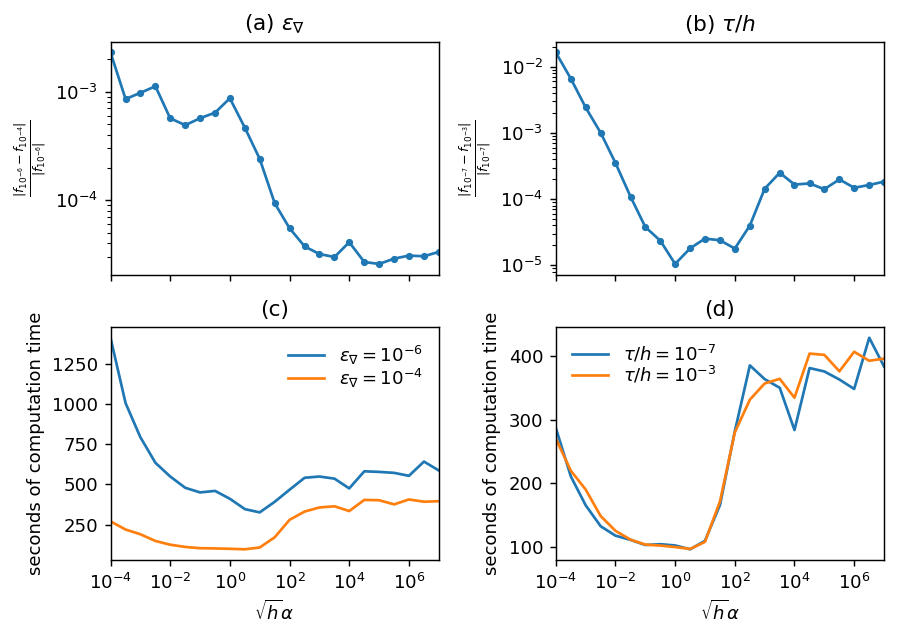

In [4]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(7, 5), dpi=130, sharex=True)


for ax in [ax1, ax2]:
    plt.sca(ax)
    if ax is ax1:
        runs1 = load('F10k3Lsp_alpha_gradflow')
    if ax is ax2:
        runs1 = load('F10k3Lsp_alpha_vanilla', predicate=lambda args: args.tau_over_h == 1e-7)
    runs1 = [r for r in runs1 if nd(r['regular']['train'], r['args'].alpha) == 0]
    print_info(r['args'] for r in runs1)

    runs2 = load('F10k3Lsp_alpha/', predicate=lambda args: args.h == 100 and args.init_seed < 5)

    ais1 = {(r['args'].alpha, r['args'].init_seed) for r in runs1}
    ais2 = {(r['args'].alpha, r['args'].init_seed) for r in runs2}
    ais = ais1.intersection(ais2)

    als = sorted({a for a, i in ais})
    runs = [
        [
            (
                next(r for r in runs1 if (r['args'].alpha, r['args'].init_seed) == (a, i)), 
                next(r for r in runs2 if (r['args'].alpha, r['args'].init_seed) == (a, i))
            )
            for i in [i for aa, i in ais if aa == a]
        ]
        for a in als
    ]

    print([len(rs) for rs in runs])

    vs = [mean(
        (r1['regular']['test']['outputs'] - r2['regular']['test']['outputs']).pow(2).mean().sqrt() 
        / r1['regular']['test']['outputs'].pow(2).mean().sqrt() 
        for r1, r2 in rs) for a, rs in zip(als, runs)]
    plt.plot(als, vs, '.-')

    plt.xscale('log')
    plt.yscale('log')

    if ax is ax1:
        plt.ylabel(r'$\frac{\| f_{10^{-6}} - f_{10^{-4}} \|}{\| f_{10^{-6}} \|}$')
    if ax is ax2:
        plt.ylabel(r'$\frac{\| f_{10^{-7}} - f_{10^{-3}} \|}{\| f_{10^{-7}} \|}$')





for ax in [ax3, ax4]:
    plt.sca(ax)

    if ax is ax3:
        runs = load('F10k3Lsp_alpha_gradflow')
        runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
        label = r'$\epsilon_\nabla = 10^{-6}$'
        als = sorted({r['args'].alpha for r in runs})
        vs = [mean(r['regular']['dynamics'][-1]['wall'] for r in runs if r['args'].alpha == a) for a in als]
        plt.plot(als, vs, label=label)
    if ax is ax4:
        runs = load('F10k3Lsp_alpha_vanilla', predicate=lambda args: args.tau_over_h == 1e-7)
        runs = [r for r in runs if nd(r['regular']['train'], r['args'].alpha) == 0]
        label = r'$\tau / h = 10^{-7}$'
        als = sorted({r['args'].alpha for r in runs})
        vs = [mean(r['regular']['dynamics'][-1]['wall'] for r in runs if r['args'].alpha == a) for a in als]
        plt.plot(als, vs, label=label)

#         runs = load('F3Lsp_alpha_vanilla', predicate=lambda args: args.tau_over_h == 1e-5)
#         label = r'$\tau / h = 10^{-5}$'
#         als = sorted({r['args'].alpha for r in runs})
#         vs = [mean(r['regular']['dynamics'][-1]['wall'] for r in runs if r['args'].alpha == a) for a in als]
#         plt.plot(als, vs, label=label)

    runs = load('F10k3Lsp_alpha', predicate=lambda args: args.h == 100)
    label = r'$\epsilon_\nabla = 10^{-4}$' if ax is ax3 else r'$\tau / h = 10^{-3}$'
    als = sorted({r['args'].alpha for r in runs})
    vs = [mean(r['regular']['dynamics'][-1]['wall'] for r in runs if r['args'].alpha == a) for a in als]
    plt.plot(als, vs, label=label)

    plt.xscale('log')
    plt.legend(frameon=False, labelspacing=0)
    plt.xlabel(r'$\sqrt{h}\alpha$')
    plt.ylabel('seconds of computation time')
    plt.xlim(min(als), max(als))



for ax, le in zip([ax1, ax2, ax3, ax4], 'abcd'):
    plt.sca(ax)
    plt.title("({})".format(le))

plt.sca(ax1)
plt.title(r'(a) $\epsilon_\nabla$')

plt.sca(ax2)
plt.title(r'(b) $\tau / h$')


plt.tight_layout()
plt.savefig('sanity_check.pgf')